先导入必要的库。

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import backtesting as bt
import pyfolio as pf
import quantstats as qs
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import datetime

读取数据，并做必要的预处理。

In [2]:
hs300 = pd.read_csv('hs300.csv')
cons = pd.read_csv('hs300_constituent_stocks.csv')
pred = pd.read_csv('hs300_constituent_stocks_predict.csv')

hs300.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'amount', 'pct_change']
cons.columns = ['date', 'code', 'open', 'high', 'low', 'close', 'volume', 'amount', 'market_cap', 'float_shares', 'pct_change', 'weight']

hs300['date'] = pd.to_datetime(hs300['date'])
cons['date'] = pd.to_datetime(cons['date'])
pred['date'] = pd.to_datetime(pred['date'])

hs300 = hs300.set_index('date')
cons = cons.set_index('date')

display(hs300)
display(cons)
display(pred)

,open,high,low,close,volume,amount,pct_change
date,,,,,,,
2007-01-04,2073.25,2139.49,2054.24,2067.09,1067197.07,8238107.26,1.28
2007-01-05,2051.15,2083.40,2030.76,2072.88,927434.47,6802606.02,0.28
2007-01-08,2072.01,2131.74,2071.72,2131.56,847679.09,6630393.61,2.83
2007-01-09,2137.49,2201.36,2128.06,2200.09,815776.29,6545619.27,3.22
2007-01-10,2210.76,2255.97,2194.77,2255.97,849049.79,6882262.48,2.54
...,...,...,...,...,...,...,...
2023-12-25,3330.33,3348.88,3330.33,3347.45,745426.93,12183832.71,0.31
2023-12-26,3345.40,3345.42,3315.94,3324.79,747329.35,12168999.74,-0.68
2023-12-27,3326.93,3341.27,3309.67,3336.36,944039.28,14092492.37,0.35


,code,open,high,low,close,volume,amount,market_cap,float_shares,pct_change,weight
date,,,,,,,,,,,
2007-01-04,1,14.65,15.32,13.83,14.11,69207082.0,1.016723e+09,2.745555e+10,1.409362e+09,-0.024900,1.270
2007-01-04,2,15.70,16.56,15.28,15.48,75119519.0,1.206786e+09,6.764603e+10,3.254255e+09,0.002600,3.320
2007-01-04,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.160
2007-01-04,12,11.15,11.30,10.66,10.95,6934903.0,7.560341e+07,1.111932e+10,2.176753e+08,-0.004500,0.140
2007-01-04,21,8.38,8.75,8.33,8.38,9271213.0,7.938714e+07,7.370365e+09,3.116781e+08,0.006000,0.170
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29,688363,67.54,67.98,66.89,66.93,2537752.0,1.707659e+08,3.223872e+10,1.981782e+08,-0.015591,0.080
2023-12-29,688396,44.57,44.94,44.18,44.69,2923514.0,1.303507e+08,5.899491e+10,1.320092e+09,0.001344,0.144
2023-12-29,688561,40.19,40.43,39.65,40.09,3084376.0,1.233603e+08,2.746856e+10,4.636838e+08,0.002501,0.072


,date,code,pred
0,2021-01-04,1,183.0
1,2021-01-04,2,279.0
2,2021-01-04,63,192.0
3,2021-01-04,66,259.0
4,2021-01-04,69,165.0
...,...,...,...
224244,2024-02-08,688363,72.0
224245,2024-02-08,688396,274.0
224246,2024-02-08,688561,45.0
224247,2024-02-08,688599,20.0


## 第一题

设 $r(i, h)$ 为已知第 $i$ 天收盘时仓位为 $h$ 时，从第 $i$ 天算起直到回测周期结束时有可能取得的最大累计收益。Bellman 方程：
$$
r(i, h) = \max_{k_i}\quad (h+k_i)(p_{i+1}-p_i) + r(i+1, h+k_i),\quad \text{s.t.} \quad -10\leq k_i\leq10.
$$

不失一般性，我们将 $k_i$ 和 $h_i$ 视为连续变量。定义函数 $r^\pi(i, h)$ 表示在第 $i$ 天收盘时仓位为 $h$ 时，如果采取策略 $\pi=(\pi_i)$，即在第 $i$ 天加仓 $\pi_i$，从第 $i$ 天算起直到回测周期结束时取得的累计收益。于是
$$
r^\pi(i, h) = (h+\pi_i)(p_{i+1}-p_i) + r^\pi(i+1, h+\pi_i).
$$

于是最优化问题为
$$
\max_{\pi}\quad r^\pi(0, 0),\quad \text{s.t.} \quad -10\leq \pi_i\leq10,
$$

为求解上述问题，我们采取梯度下降法找到最优参数。

In [3]:
class Strategy(nn.Module):
    def __init__(self, hs300, time_length):
        '''
        hs300 为指数历史数据
        '''
        super().__init__()

        assert len(hs300) == time_length
        self.time_length = time_length

        # 取出每日的收盘价
        self.close = torch.tensor(hs300['close'].values, dtype=torch.float32)
        self.close.requires_grad = False

        # operation 表示每天的加减仓，随机初始化，限制在 -10 和 10 之间
        self.operation = nn.Parameter((torch.rand(time_length) - 0.5) * 20, requires_grad=True)
    
    def r(self, i, h, operation):
        '''
        即为 r^pi(i, h)，operation 即为 pi
        i 表示当前时间点，h 表示当前的仓位，operation 表示每天的加减仓
        使用递归方法计算 r^pi(i, h)，跟踪梯度
        '''
        if i == self.time_length - 1:
            return 0
        delta = self.close[i + 1] - self.close[i]  # 价差
        k = operation[i + 1]
        h_ = torch.clamp(h + k, 0, 100)  # 新的仓位
        return self.r(i + 1, h_, operation) + delta * h_  # Bellman 方程
    
    def forward(self):
        h = self.operation[0]
        return self.r(0, h, self.operation)

开始训练。先取出回测窗口。

In [4]:
hs300_test = hs300.loc['2020-01-02':'2023-12-29']
time_length = len(hs300_test)

100%|██████████| 150/150 [00:10<00:00, 14.74it/s]


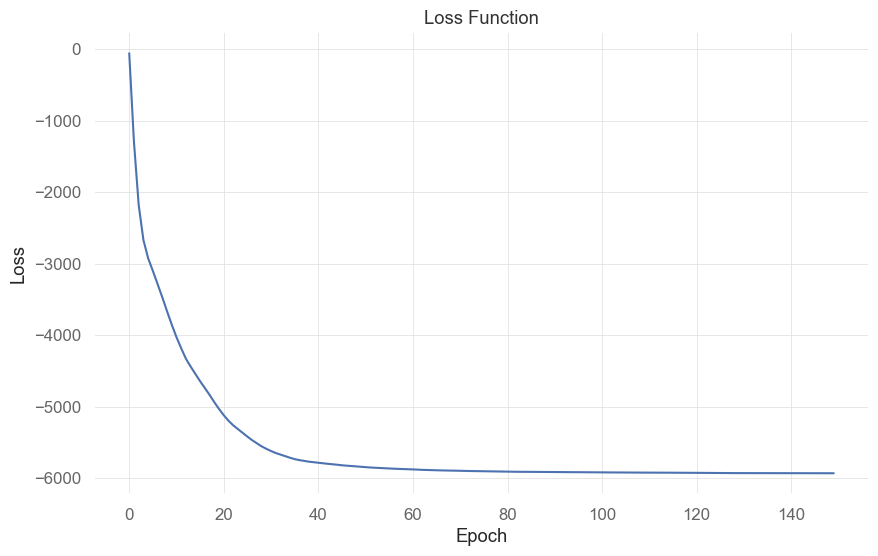

In [5]:
strategy = Strategy(hs300_test, time_length)
optimizer = optim.Adam(strategy.parameters(), lr=1)
losses = []

for epoch in tqdm(range(150)):
    optimizer.zero_grad()
    loss = -strategy.forward()/100  # 由于仓位最高为 100 单位，除以 100 归一化保证与指数的可比性
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        strategy.operation.clamp_(-10, 10)  # 交易限制
    losses.append(loss.item())

# 画出损失函数
plt.plot(losses)
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

训练完成后，提取出 `operation` 即为每日的加减仓操作。

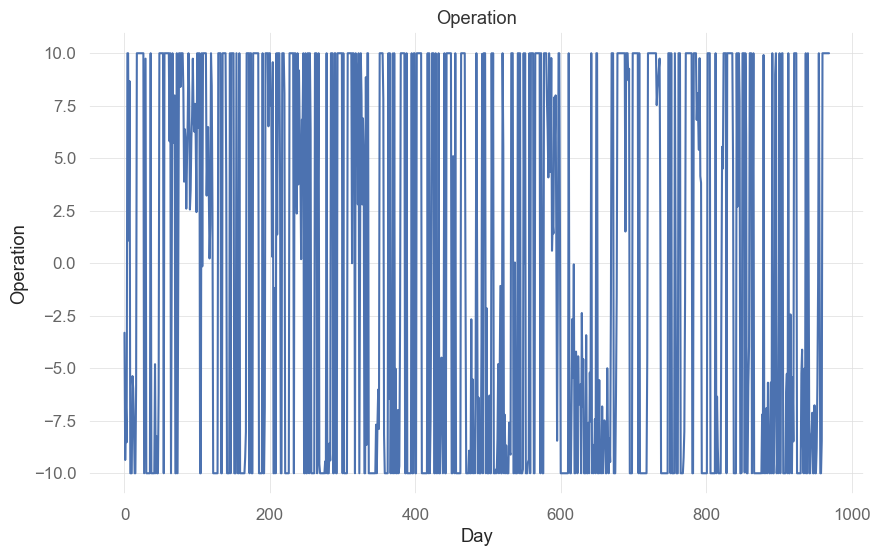

In [6]:
operation = strategy.operation.cpu().detach().numpy()
plt.plot(operation)
plt.title('Operation')
plt.xlabel('Day')
plt.ylabel('Operation')
plt.show()

绘制每天的仓位高低变化。

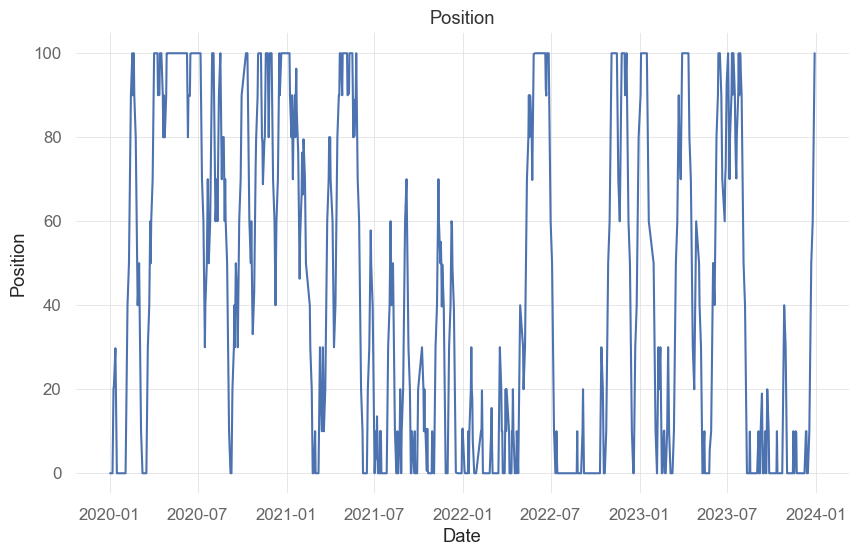

In [7]:
returns = np.zeros(time_length)  # 用于储存累计收益
prices = hs300_test['close'].values  # 每日收盘价
holds = np.zeros(time_length)  # 每日仓位
holds[0] = operation[0]  # 第一天的仓位
holds[0] = np.clip(holds[0], 0, 100)  # 限制在 0 和 100 之间

for i in range(1, time_length):
    delta = prices[i] - prices[i - 1]
    k = operation[i]
    holds[i] = np.clip(holds[i - 1] + k, 0, 100)
    returns[i] = returns[i - 1] + delta * holds[i]

returns = returns / 100  # 归一化

# 画出仓位
plt.plot(hs300_test.index, holds)
plt.title('Position')
plt.xlabel('Date')
plt.ylabel('Position')
plt.show()

与沪深 300 指数对比查看策略效果。

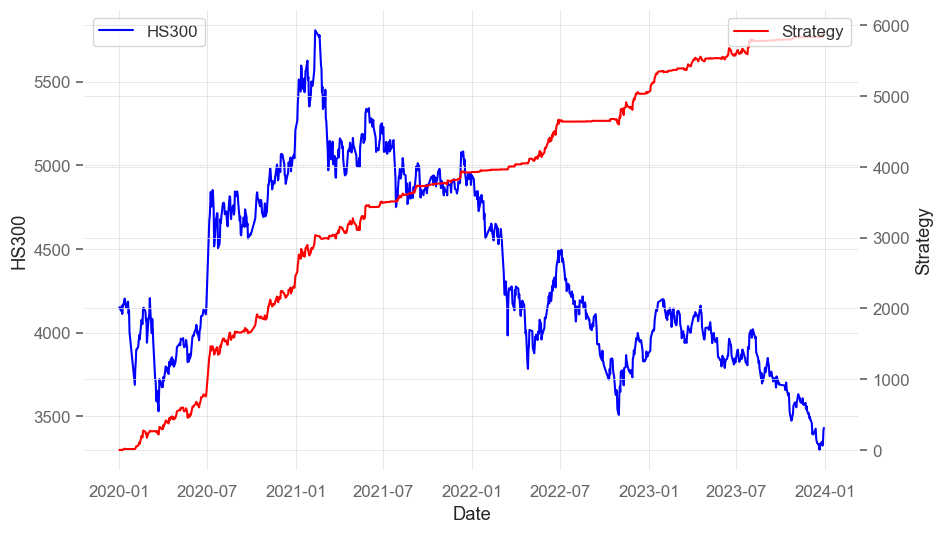

In [8]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(hs300_test.index, hs300_test['close'], color='blue', label='HS300')
ax2.plot(hs300_test.index, returns, color='red', label='Strategy')
ax1.set_xlabel('Date')
ax1.set_ylabel('HS300')
ax2.set_ylabel('Strategy')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

设第 $i$ 日收盘时持仓市值为 $V_i$，第 $i$ 日收盘时累计收益为 $R_i$，我们设定本金为
$$
\max_i\quad V_i - R_i,
$$
即理论上要执行这个投资策略需要事先准备的最小资金。

In [12]:
holds = pd.Series(holds, index=hs300_test.index)
values = holds * hs300_test['close']/100  # 每日市值
fund = (values - returns).max()  # 本金
fund

3877.806703014517

于是可以进一步计算更多技术指标。需要注意，由于随机性，每次优化出来的策略可能略有差异。

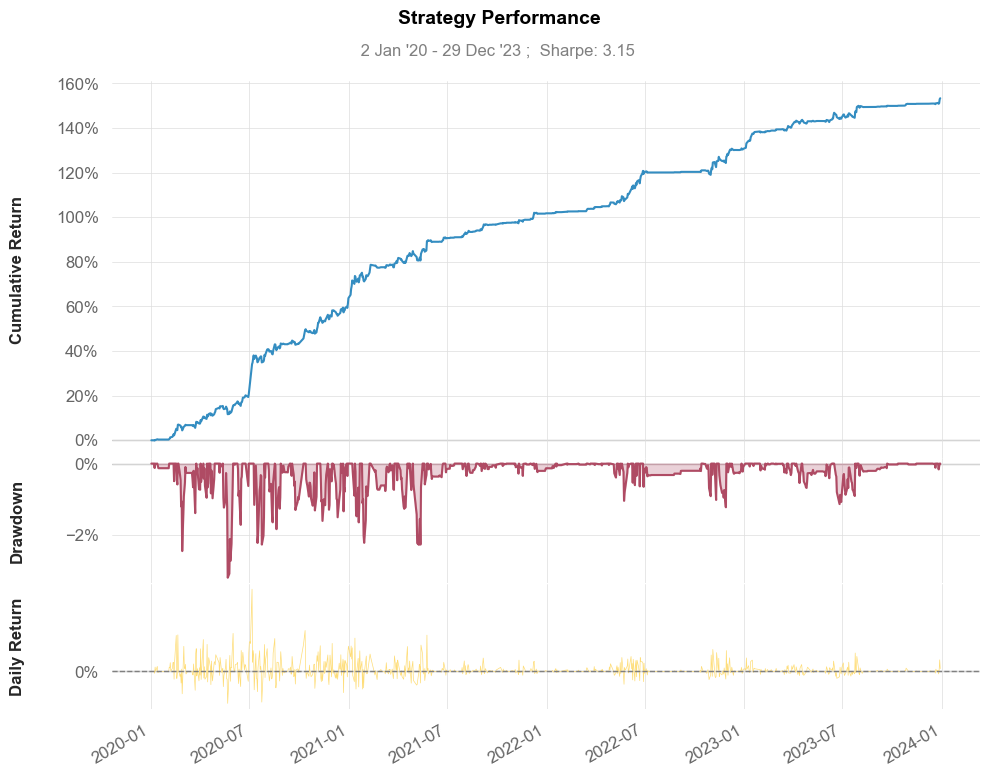

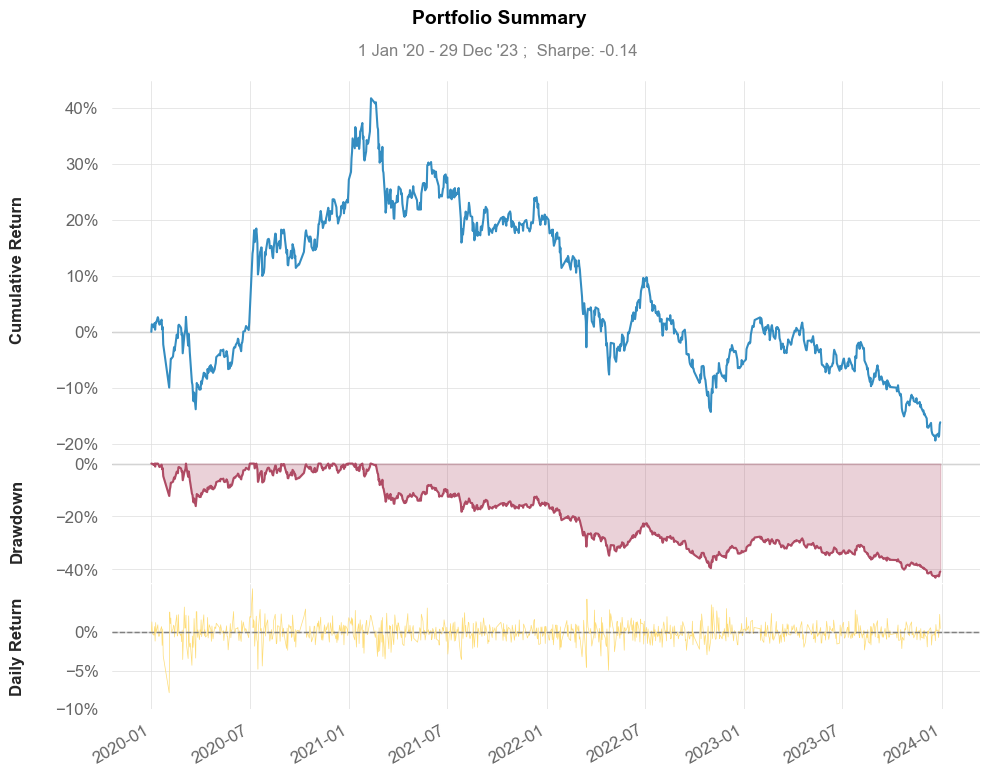

In [13]:
returns = pd.Series(returns, index=hs300_test.index)
daily_returns = returns.diff() / fund  # 以固定本金计算的日收益率

qs.plots.snapshot(daily_returns, mode='', title='Strategy Performance')
plt.show()

daily_hs300 = hs300_test['pct_change'] / 100
qs.plots.snapshot(daily_hs300, mode='comp')
plt.show()

同时可以计算最大回撤。

In [14]:
daily_returns_comp = (fund + returns).pct_change()  # 复利计算的日收益率
qs.stats.max_drawdown(daily_returns_comp)

-0.03220142573493934

## 第二题

### 指标分析

#### 整体属性

在真正设计投资组合之前，我们先查看预测值的表现如何。我们先得到各成分股的未来 `t` 日的累计收益率，查看预测的排名在总体上是否与未来的实际收益率排名一致。

取出回测窗口。

In [16]:
cons_test = cons.loc['2021-01-04':'2023-12-31']

在对不同的 `t` 分析以前，我们先在时序维度上，看看 `t=30` 时预测效果如何。首先先计算累计收益率。

In [20]:
t = 30

# 计算每只股票未来 t 天的累计收益率
def calculate_cumulative_return(group):
    group['cumulative_return'] = (group['close'].shift(-t) - group['close']) / group['close']
    return group

cons_cum = cons_test.groupby('code').apply(calculate_cumulative_return, include_groups=False)

cons_cum

open   high    low  close       volume        amount  \
code   date                                                                
1      2021-01-04  19.10  19.10  18.44  18.60  155421643.0  2.891682e+09   
       2021-01-05  18.40  18.48  17.80  18.17  182135210.0  3.284607e+09   
       2021-01-06  18.08  19.56  18.00  19.56  193494512.0  3.648522e+09   
       2021-01-07  19.52  19.98  19.23  19.90  158418530.0  3.111275e+09   
       2021-01-08  19.90  20.10  19.31  19.85  119547322.0  2.348316e+09   
...                  ...    ...    ...    ...          ...           ...   
688981 2023-12-25  54.60  55.00  52.85  53.01   17788368.0  9.541097e+08   
       2023-12-26  53.01  53.23  51.80  51.85   14401632.0  7.540936e+08   
       2023-12-27  51.83  52.29  51.18  51.91   15173450.0  7.864514e+08   
       2023-12-28  51.70  53.45  51.68  53.13   19211860.0  1.015243e+09   
       2023-12-29  53.00  53.50  52.88  53.02   12648666.0  6.719192e+08   

                     market_cap  float_shares  pct_change  weight  \
code   date                                                         
1      2021-01-04  3.609501e+11  1.940575e+10   -0.038263  0.9102   
       2021-01-05  3.526055e+11  1.940575e+10   -0.023118  0.9102   
       2021-01-06  3.795798e+11  1.940575e+10    0.076500  0.9102   
       2021-01-07  3.861778e+11  1.940575e+10    0.017382  0.9102   
       2021-01-08  3.852075e+11  1.940575e+10   -0.002513  0.9102   
...                         ...           ...         ...     ...   
688981 2023-12-25  4.212462e+11  1.973609e+09   -0.032488  0.6100   
       2023-12-26  4.120282e+11  1.973609e+09   -0.021883  0.6100   
       2023-12-27  4.125050e+11  1.973609e+09    0.001157  0.6100   
       2023-12-28  4.221998e+11  1.973609e+09    0.023502  0.6100   
       2023-12-29  4.213257e+11  1.973609e+09   -0.002070  0.6100   

                   cumulative_return  
code   date                           
1      2021-01-04           0.203226  
       2021-01-05           0.206935  
       2021-01-06           0.132924  
       2021-01-07           0.110050  
       2021-01-08           0.077078  
...                              ...  
688981 2023-12-25                NaN  
       2023-12-26                NaN  
       2023-12-27                NaN  
       2023-12-28                NaN  
       2023-12-29                NaN  

[218100 rows x 11 columns]

获得累计收益率之后，我们就可以在每个交易日根据未来 `t` 日的累计收益率进行排序，得到一个排名序列。

In [21]:
def rank_stocks(group):
    group['rank'] = group['cumulative_return'].rank(ascending=False)
    return group

cum_ranked = cons_cum.groupby('date').apply(rank_stocks)
cum_ranked = cum_ranked[['rank']]
cum_ranked.index = cum_ranked.index.droplevel(2)
cum_ranked

rank
date       code         
2021-01-04 1        46.0
           2       106.0
           63      200.0
           66      293.0
           69       51.0
...                  ...
2023-12-29 688363    NaN
           688396    NaN
           688561    NaN
           688599    NaN
           688981    NaN

[218100 rows x 1 columns]

现在我们可以计算预测值的排名与实际收益率的排名之间的相关性。预处理预测排名 `pred`，保持和 `cum_ranked` 一致的结构。

In [27]:
pred_test = pred[pred['date'].isin(cons_test.index)].groupby('date')
pred_test = pred_test.apply(lambda x: x.set_index('code'), include_groups=False)
pred_test

pred
date       code         
2021-01-04 1       183.0
           2       279.0
           63      192.0
           66      259.0
           69      165.0
...                  ...
2023-12-29 688363  113.0
           688396  224.0
           688561  135.0
           688599   16.0
           688981  254.0

[215909 rows x 1 columns]

接着就可以计算相关性，并在时序维度上画出相关性图像。

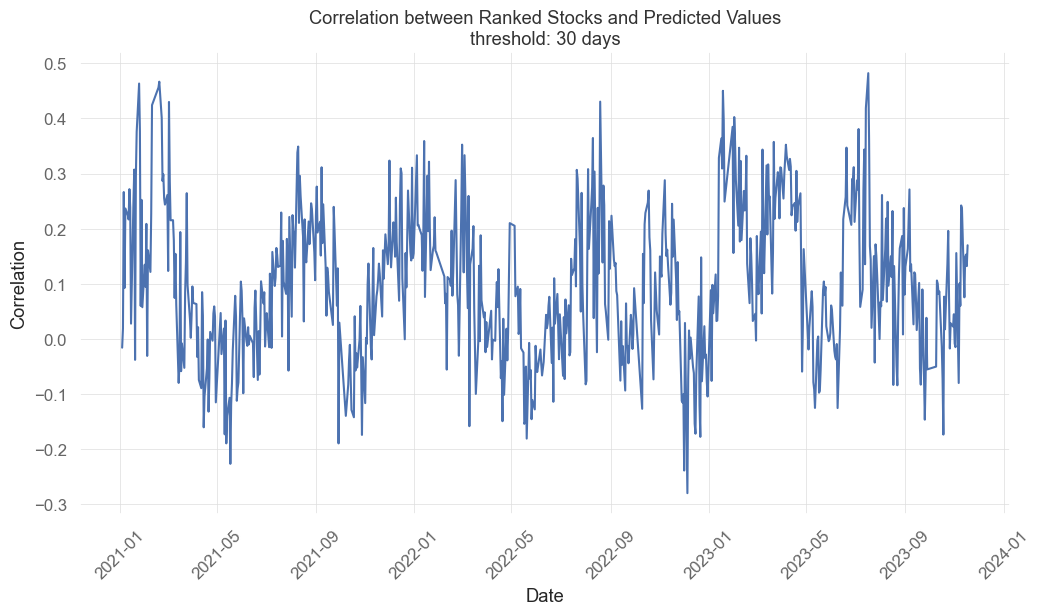

In [31]:
def calculate_correlation(group):
    ranked = cum_ranked.loc[group.index]
    pred = group['pred']
    correlation = ranked.corrwith(pred)
    return correlation

correlations = pred_test.groupby('date').apply(calculate_correlation)
correlations = correlations.dropna()

# 绘制相关性图
plt.figure(figsize=(12, 6))
plt.plot(correlations.index, correlations.values)
plt.title(f'Correlation between Ranked Stocks and Predicted Values\nthreshold: {t} days')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.show()

从整体的相关性来说，只能观察出来相关性大于零的居多。我们希望对比一下，对于不同的 `t`，相关性是否有差异。我们可以计算不同 `t` 的相关性均值和标准差。

In [37]:
ts = [i for i in range(1, 301)]
corr = {}  # 用于存储不同 t 的相关性数据

for t in tqdm(ts):
    def calculate_cumulative_return(group):
        group['cumulative_return'] = (group['close'].shift(-t) - group['close']) / group['close']
        return group
    
    cons_cum = cons_test.groupby('code').apply(calculate_cumulative_return, include_groups=False)
    cum_ranked = cons_cum.groupby('date').apply(rank_stocks)
    cum_ranked = cum_ranked[['rank']]
    cum_ranked.index = cum_ranked.index.droplevel(2)
    correlations = pred_test.groupby('date').apply(calculate_correlation, include_groups=False)
    correlations = correlations.dropna()
    corr[t] = correlations

100%|██████████| 300/300 [05:46<00:00,  1.15s/it]


我们计算不同 `t` 的相关性均值和标准差，并绘图比较。

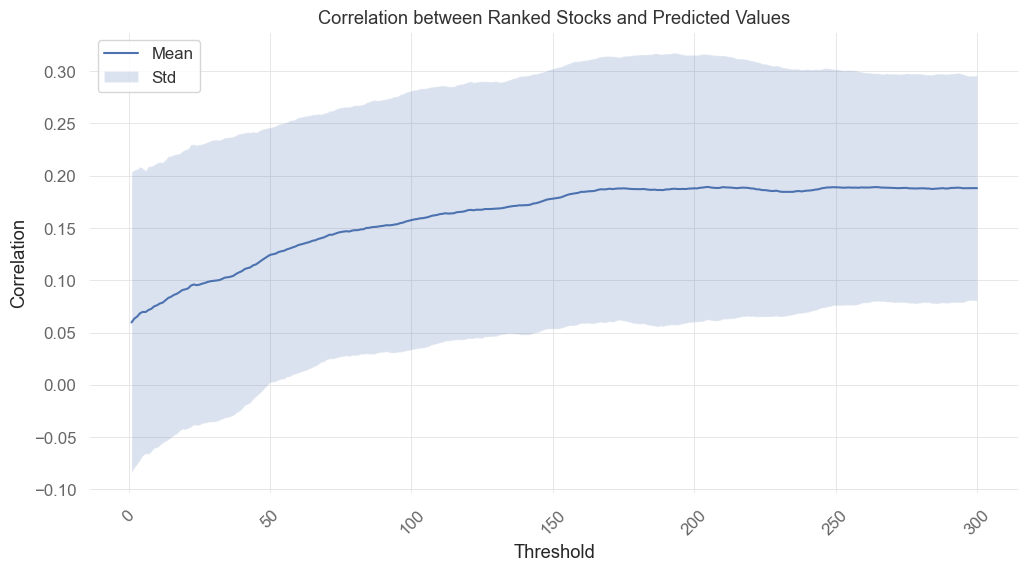

In [ ]:
corr_mean = {}
corr_std = {}

for k, v in corr.items():
    corr_mean[k] = v.mean()
    corr_std[k] = v.std()

plt.figure(figsize=(12, 6))
plt.plot(corr_mean.keys(), corr_mean.values(), label='Mean')

low = np.array(list(corr_mean.values())) - np.array(list(corr_std.values()))
high = np.array(list(corr_mean.values())) + np.array(list(corr_std.values()))
low = low.flatten()
high = high.flatten()
plt.fill_between(corr_mean.keys(), low, high, alpha=0.2, label='Std')

plt.title('Correlation between Ranked Stocks and Predicted Values')
plt.xlabel('Threshold')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.legend()
plt.show()

尽管相关性对于不同 `t` 展现出了一定的递增关系，但是最高也不超过 0.2，同时相关性是对所有成分股做的，也包括那些收益不好的股票，因此预测值在这方面不能提供很好的指导

下一步的想法是，预测值是否在连续的天数内表现出一定一致性？我们可以计算不同交易日之间预测值的相关性。

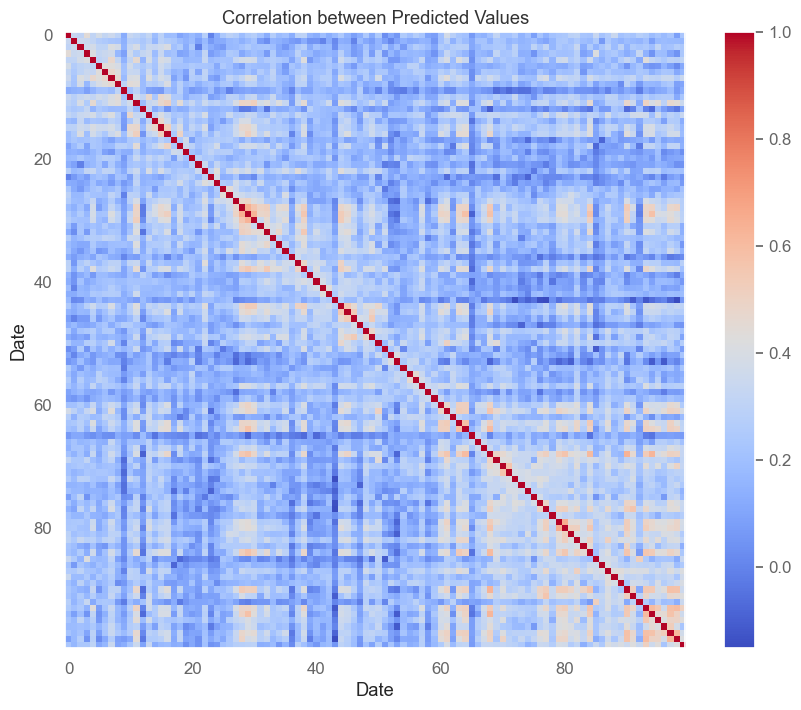

In [43]:
pred_pivot = pred_test.reset_index().pivot(index='code', columns='date', values='pred')
pred_corr = pred_pivot.corr()

# 取左上角
pred_corr = pred_corr.iloc[:100, :100]

plt.figure(figsize=(10, 8))
plt.imshow(pred_corr, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.title('Correlation between Predicted Values')
plt.xlabel('Date')
plt.ylabel('Date')
plt.grid()
plt.show()

可以发现，预测的一致性也不能保证，或者我们应当猜测，该预测值有比较强的时效性。从整体层面，暂时不能看出预测值的属性对我们构建投资组合有什么帮助。

#### 分级属性

尽管总体的属性不一定能提供指引，预测值的个别预测可能具有显著性或一致性。

为了继续探究，我们先取出回测窗口。

In [66]:
# 都在 2021 年 1 月 4 日到 2023 年 12 月 29 日之间
cons_test = cons[cons.index.isin(pred['date'])]
pred_test = pred[pred.date.isin(cons.index)]
hs300_test = hs300[hs300.index.isin(pred['date'])]

pred_pivot = pred_test.pivot(index='date', columns='code', values='pred')

我们希望查看，每日不同排名的日收益率有没有显著差异。为此，我们先给出计算收益率的函数。先取出回测窗口内的收益率数据。由于沪深 300 的成分股是动态的，对于退出的成分股，我们希望投资组合中不再追踪，也即收益率默认为 0，相当于强制清仓退出的成分股，于是我们将收益率缺失值填充为 0。

In [61]:
cons_pivot = cons_test.pivot(columns='code', values='pct_change').fillna(0)
cons_pivot

code,1,2,63,66,69,100,157,166,301,333,...,688126,688169,688187,688223,688303,688363,688396,688561,688599,688981
date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.038263,-0.032056,0.020208,0.090047,-0.028209,0.014124,0.032323,-0.001894,0.000000,0.005790,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-05,-0.023118,0.004680,0.005243,-0.002415,0.002903,0.029248,0.051859,-0.003795,0.000000,0.025553,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-06,0.076500,0.030097,-0.025500,-0.016949,-0.014472,-0.014885,-0.001860,-0.009524,0.000000,-0.005712,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-07,0.017382,0.001391,-0.028546,-0.034483,-0.014684,0.009615,0.073625,0.003846,0.000000,0.038233,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2021-01-08,-0.002513,0.019104,0.037649,0.003061,0.004471,0.016327,0.029514,0.005747,0.000000,-0.017268,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,-0.001087,-0.007707,0.005959,0.000000,0.000000,0.015345,0.009288,0.004556,0.028571,-0.001895,...,0.005907,0.0,0.004619,0.011947,0.008502,0.010058,0.004774,0.015787,-0.001516,-0.032488
2023-12-26,-0.009793,-0.012621,-0.026856,0.000000,-0.016393,-0.007557,-0.009202,-0.011338,0.040000,0.002468,...,-0.021139,0.0,-0.008621,-0.011806,-0.007025,-0.003890,-0.029412,-0.024204,0.000380,-0.021883
2023-12-27,0.002198,0.000000,0.000000,0.000000,0.006667,0.048223,0.012384,0.009174,0.000000,0.015152,...,-0.011998,0.0,0.002609,0.002389,-0.013088,-0.008747,0.010490,-0.004700,-0.009105,0.001157


与此同时，数据提供的涨跌幅是相对于前一天的收盘价的，也即是
$$
pct\_change_i = \frac{close_i-close_{i-1}}{close_{i-1}}.
$$

而当天的预测排名是已经观察完当天的股价后做出的，因此计算当天收益率时应该只能使用前一天的预测排名，也就是说要错开一天，因此我们去掉收益率的第一行，同时把每天的投资组合解释为当天收盘后观察到预测值，为下一个交易日设计投资组合。

In [62]:
cons_pivot = cons_pivot.iloc[1:]

设第 $i$ 天时沪深 300 的成分股为 $(s_{i,1}, s_{i,2}, \ldots, s_{i,300})$，第 $i$ 天时各成分股的权重为 $(w_{i,1}, w_{i,2}, \ldots, w_{i,300})$，第 $i$ 天时各成分股的收益率为 $(r_{i,1}, r_{i,2}, \ldots, r_{i,300})$。我们可以定义加权收益率为
$$
R_i = \sum_{j=1}^{300} w_{i,j} r_{i,j}.
$$

假定 `portfolio` 是和 `pred_pivot` 一样的结构，但应当少掉最后一行，出于我们刚刚说明的原因。于是我们可以给出计算收益率的方法。

In [76]:
def cal_return(portfolio):
    portfolio_pct_change = cons_pivot.dot(portfolio.T)
    # 取对角线即为每日收益
    portfolio_pct_change = portfolio_pct_change.values.diagonal()
    portfolio_pct_change = pd.Series(portfolio_pct_change, index=portfolio.index)
    portfolio_pct_change = portfolio_pct_change.dropna()
    return portfolio_pct_change

完成上述工作，我们就可以尝试对每天的排名进行分组，查看是否排名越靠前，当天的收益率越高。

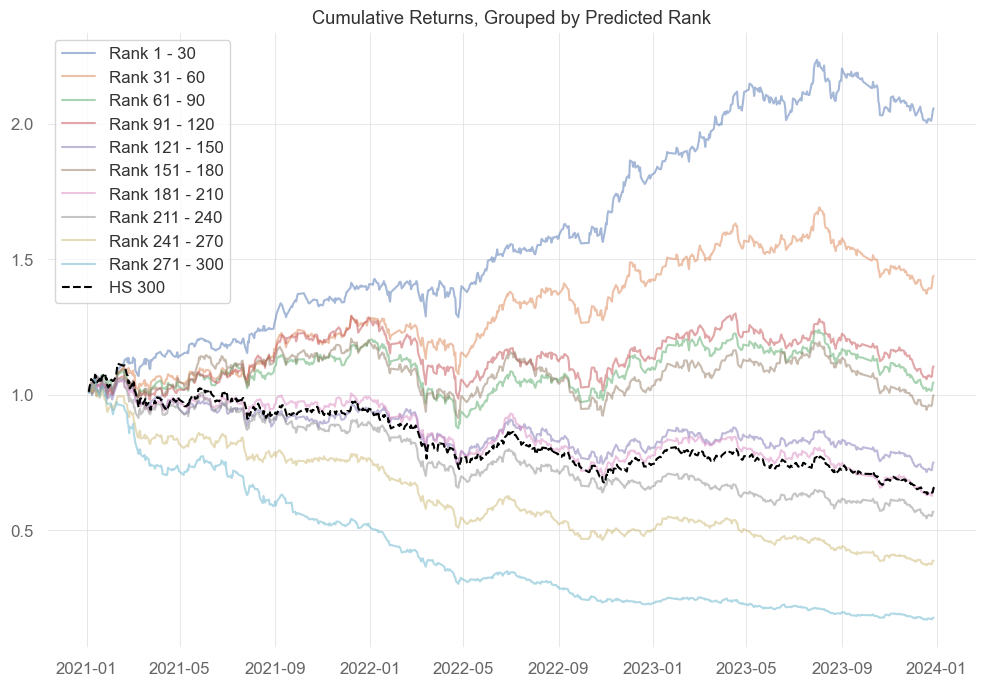

In [71]:
def get_bins(pred_pivot, bin_width=30, max_rank=300):
    bins = []
    for i in range(1, max_rank, bin_width):
        bin_portfolio = pred_pivot >= i  # 排名大于等于 i 
        bin_portfolio = bin_portfolio & (pred_pivot < i + bin_width)  # 同时排名小于 i + bin_width
        bin_portfolio  = bin_portfolio.drop(bin_portfolio.index[-1])  # 删除最后一天的数据
        bin_portfolio = bin_portfolio.div(bin_portfolio.sum(axis=1), axis=0)  # 保证投资组合的权重和为 1
        bin_portfolio = bin_portfolio.fillna(0)
        bin_return = cal_return(bin_portfolio)
        bin_cum_return = (1 + bin_return).cumprod()
        bins.append(bin_cum_return)
    return bins

def plot_bins(bins, bin_width=30):
    plt.figure(figsize=(12, 8))
    for i in range(len(bins)):
        plt.plot(bins[i], label=f'Rank {i * bin_width + 1} - {(i + 1) * bin_width}', alpha=0.5)

    # 沪深 300 作为对比
    plt.plot((1 + hs300_test['pct_change']/100).cumprod(), label='HS 300', color='black', linestyle='--')

    plt.legend()
    plt.title('Cumulative Returns, Grouped by Predicted Rank')
    plt.show()

bins = get_bins(pred_pivot)
plot_bins(bins)

其实可以发现，分级来看，预测值就提供了非常有效的指引。按照预测值的排名前 30 构建投资组合能够获得远高于其他组合的收益率。同时我们发现，60-180 名的预测值就不一定那么准确。我们现在对前 30 名进行更细致的分组，查看预测值的有效性。

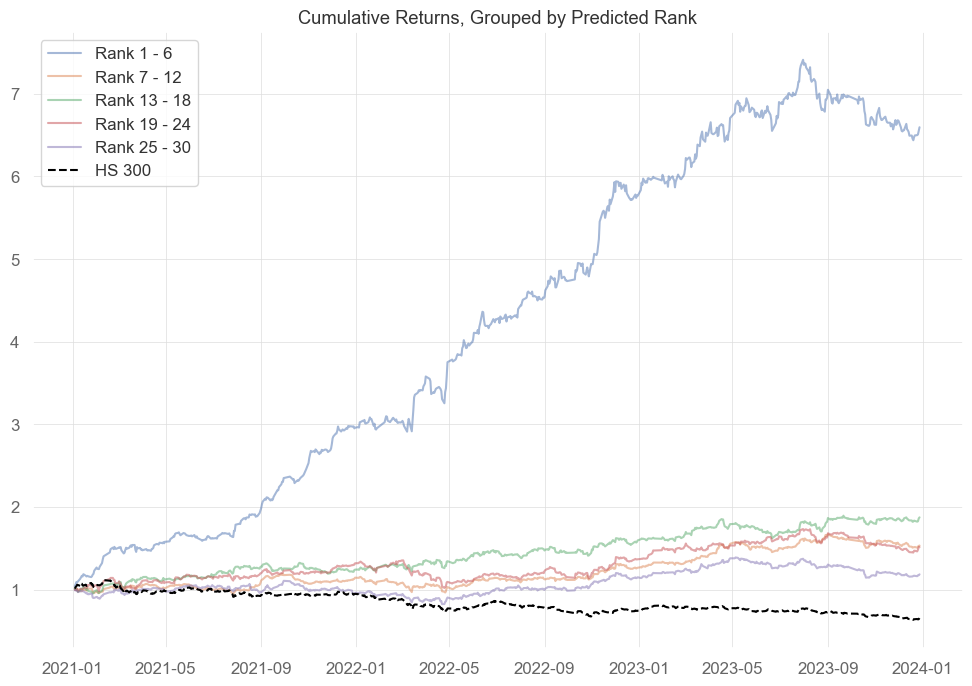

In [74]:
bins = get_bins(pred_pivot, bin_width=6, max_rank=30)
plot_bins(bins, bin_width=6)

可以发现，预测值有非常明显的“头部效应”，前 6 名的组合价值在三年间变为原来的 7 倍，收益率远高于其他排名的收益率。我们再进一步查看前 6 名的收益率。

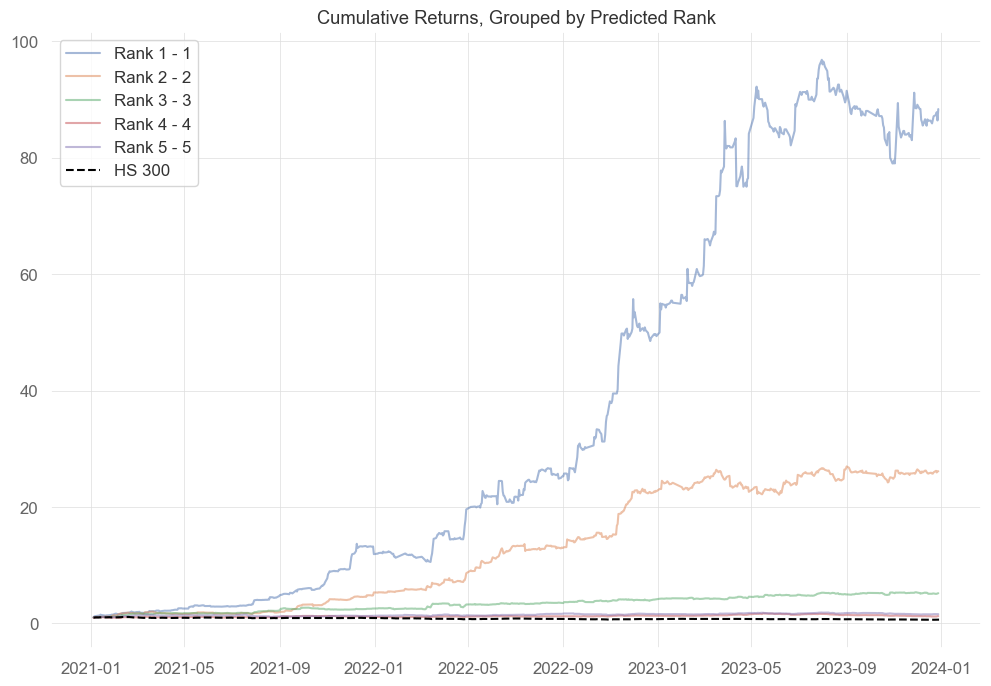

In [75]:
bins = get_bins(pred_pivot, bin_width=1, max_rank=6)
plot_bins(bins, bin_width=1)

结果令人吃惊，光是每天全仓购买第 1 名股票的简单策略就能使手里的资金在 3 年内翻近 90 倍。可见预测值在分级后表现出非常强的有效性。

### Top-k 策略

我们可以查看如果我们采取购买前 k 名股票的策略究竟表现如何。先给出展示投资组合表现的函数。

In [77]:
def cal_and_plot_return(portfolio, title='Portfolio Performance'):
    portfolio_pct_change = cal_return(portfolio)
    hs300_pct_change = hs300[hs300.index.isin(portfolio_pct_change.index)].pct_change().close
    qs.plots.snapshot(portfolio_pct_change - hs300_pct_change, title=title, name='Portfolio')

注意到我们实际上使用了超额收益率
$$
R_i^* = R_i - R^{HS300}_i,
$$
其中 $R^{HS300}_i$ 为沪深 300 指数的收益率。

同时我们定义夏普比率为
$$
S_i = \frac{R_i^*}{\sigma(R_i^*)},
$$
其中 $\sigma(R_i^*)$ 为超额收益率的标准差。

现在可以构建投资组合了。

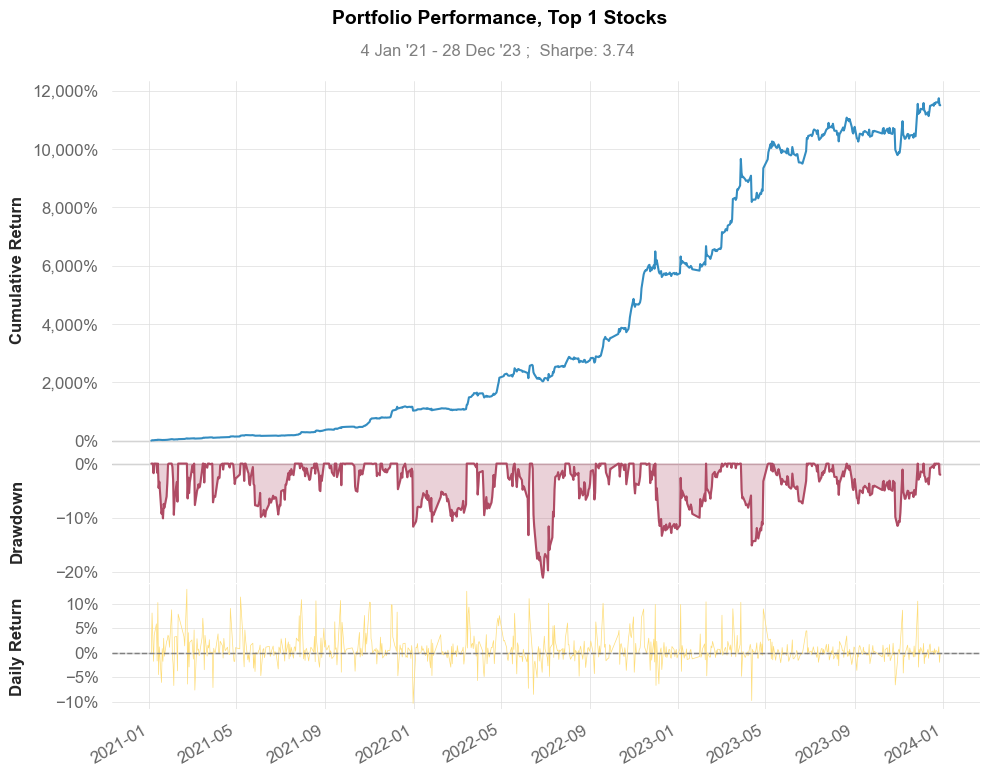

In [308]:
def buy_k_th_strategy(k):
    k_portfolio = pred_pivot <= k
    k_portfolio = k_portfolio.drop(k_portfolio.index[-1])
    k_portfolio = k_portfolio.div(k_portfolio.sum(axis=1), axis=0)  # 保证投资组合的权重和为 1
    k_portfolio = k_portfolio.fillna(0)
    return k_portfolio


k = 1
k_1_portfolio = buy_k_th_strategy(k)
cal_and_plot_return(k_1_portfolio, title=f'Portfolio Performance, Top {k} Stocks')

Top-1 策略的夏普比率达到 3.74。

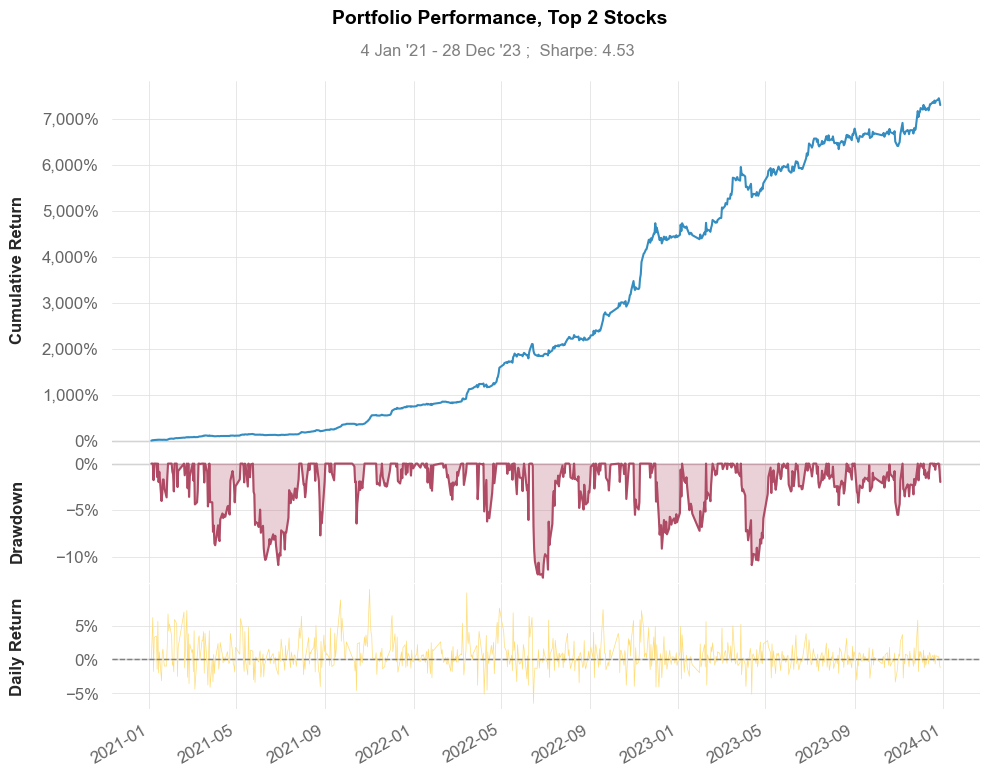

In [309]:
k = 2
k_2_portfolio = buy_k_th_strategy(k)
cal_and_plot_return(k_2_portfolio, title=f'Portfolio Performance, Top {k} Stocks')

Top-2 策略的夏普比率更是达到 4.53。

### 以 Top-k 当日收益率为基础的最优配比策略

考虑到 Top 1 策略的高收益，我们只需尝试加入第二名的股票，摊平一些风险的同时不降低太多收益，从而最大化夏普比率。

为此，我们需要在回测时动态根据回测区间内历史收益率数据计算协方差，动态调整投资组合的权重。

In [266]:
# 把每天的第 1,2 名的 pct_change 提取出来
cons_test_pivot = cons_test.pivot(columns='code', values='pct_change')  # 因为 cons_pivot 去掉了第一行

def get_top_n_stocks(pred_pivot, n=2):
    top_n = pred_pivot.apply(lambda x: x.nsmallest(n).index.tolist(), axis=1)
    top_n_pct_change = pd.DataFrame(index=pred_pivot.index, columns=range(n))
    for date in pred_pivot.index:
        for i in range(n):
            top_n_pct_change.loc[date, i] = cons_test_pivot.loc[date, top_n[date][i]]
    return top_n_pct_change

n = 2
top_n_pct_change = get_top_n_stocks(pred_pivot, n=n)
top_n_pct_change = top_n_pct_change.sub(hs300_test['pct_change']/100, axis=0)
top_n_pct_change

,0,1
date,,
2021-01-04,0.089312,-0.002253
2021-01-05,0.081104,-0.0191
2021-01-06,0.091735,0.091172
2021-01-07,-0.0177,-0.0177
2021-01-08,0.103488,0.1033
...,...,...
2023-12-25,0.005164,0.001985
2023-12-26,0.009532,0.001537
2023-12-27,0.00195,0.020824


In [267]:
top_n_mean = top_n_pct_change.expanding().mean()
top_n_cov = top_n_pct_change.expanding().cov()
top_n_mean = top_n_mean.iloc[1:]
top_n_cov.dropna(inplace=True)

display(top_n_mean)
display(top_n_cov)

,0,1
date,,
2021-01-05,0.085208,-0.010676
2021-01-06,0.087384,0.023273
2021-01-07,0.061113,0.013030
2021-01-08,0.069588,0.031084
2021-01-11,0.055271,0.028084
...,...,...
2023-12-25,0.024266,0.012490
2023-12-26,0.024245,0.012475
2023-12-27,0.024215,0.012486


0         1
date                            
2021-01-05 0  0.000034  0.000069
           1  0.000069  0.000142
2021-01-06 0  0.000031  0.000256
           1  0.000256  0.003529
2021-01-07 0  0.002781  0.001247
...                ...       ...
2023-12-27 1  0.000474  0.001137
2023-12-28 0  0.001681  0.000474
           1  0.000474  0.001135
2023-12-29 0  0.001680  0.000474
           1  0.000474  0.001134

[1452 rows x 2 columns]

假设资产 $X$ 和 $Y$ 的收益率为 $R_X$ 和 $R_Y$，协方差矩阵为
$$
\Sigma = \begin{pmatrix}
\sigma_{XX} & \sigma_{XY} \\
\sigma_{YX} & \sigma_{YY}
\end{pmatrix}.
$$

投资组合的权重为 $w_X$ 和 $w_Y$，投资组合的收益率为 $R_P$，则
$$
R_P = w_X R_X + w_Y R_Y,
$$
投资组合的方差为
$$
\sigma_P^2 = w_X^2 \sigma_{XX} + w_Y^2 \sigma_{YY} + 2 w_X w_Y \sigma_{XY},
$$
夏普比率为
$$
S = \frac{R_P}{\sigma_P} = \frac{w_X R_X + w_Y R_Y}{\sqrt{w_X^2 \sigma_{XX} + w_Y^2 \sigma_{YY} + 2 w_X w_Y \sigma_{XY}}},
$$
注意 $R_f=0$，即无风险收益率为 0。

我们的目标是最大化夏普比率 $S$，可以通过现有库函数 `scipy.optimize` 来实现。我们可以定义一个函数，输入为 $w_X$ 和 $w_Y$，输出为 $S$ 的负值。同时，要保证 $w_X+w_Y=1$，$w_X,w_Y\geq0$。

In [268]:
from scipy.optimize import minimize

def cal_sharpe_ratio(rX, rY, vX, vY, covXY, wX, wY, rf=0):
    rP = wX * rX + wY * rY
    vP = wX ** 2 * vX + wY ** 2 * vY + 2 * wX * wY * covXY
    sharpe = (rP - rf) / np.sqrt(vP)
    return sharpe

def objective_function(w, rX, rY, vX, vY, covXY):
    wX, wY = w[0], w[1]
    sharpe = cal_sharpe_ratio(rX, rY, vX, vY, covXY, wX, wY)
    return -sharpe  # 取负值，因为我们要最大化 Sharpe 比率

def optimize_weights(rX, rY, vX, vY, covXY):
    w0 = np.array([0.5, 0.5])  # 初始权重
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = ((0, 1), (0, 1))

    result = minimize(objective_function, w0, args=(rX, rY, vX, vY, covXY), method='SLSQP', bounds=bounds, constraints=constraints)

    return result.x

def get_optimal_weights(top_n_mean, top_n_cov):
    weights = {}
    for date in top_n_mean.index:
        rX = top_n_mean.loc[date][0]
        rY = top_n_mean.loc[date][1]
        vX = top_n_cov.loc[date].iloc[0, 0]
        vY = top_n_cov.loc[date].iloc[1, 1]
        covXY = top_n_cov.loc[date].iloc[0, 1]
        weights[date] = optimize_weights(rX, rY, vX, vY, covXY)
    return weights

optimal_weights = get_optimal_weights(top_n_mean, top_n_cov)
optimal_weights = pd.DataFrame(optimal_weights).T
optimal_weights

,0,1
2021-01-05,1.000000,5.628831e-14
2021-01-06,1.000000,5.384582e-15
2021-01-07,1.000000,0.000000e+00
2021-01-08,1.000000,0.000000e+00
2021-01-11,0.998641,1.358965e-03
...,...,...
2023-12-25,0.696047,3.039531e-01
2023-12-26,0.696292,3.037077e-01
2023-12-27,0.694863,3.051371e-01
2023-12-28,0.695195,3.048047e-01


有了最优权重之后，我们就可以计算最优投资组合的收益率和夏普比率了。对于第一天，默认全仓购买第 1 名股票。

In [269]:
print(f'n = {n}')
op_w_portfolio = pred_pivot <= 1
op_w_portfolio = portfolio.astype(float)

top_n = pred_pivot.apply(lambda x: x.nsmallest(n).index.tolist(), axis=1)
for date in optimal_weights.index:
    for i in range(n):
        op_w_portfolio.loc[date, top_n[date][i]] = optimal_weights.loc[date][i]

op_w_portfolio = op_w_portfolio.drop(op_w_portfolio.index[-1])
op_w_portfolio = op_w_portfolio.div(op_w_portfolio.sum(axis=1), axis=0)
op_w_portfolio = op_w_portfolio.fillna(0)

n = 2


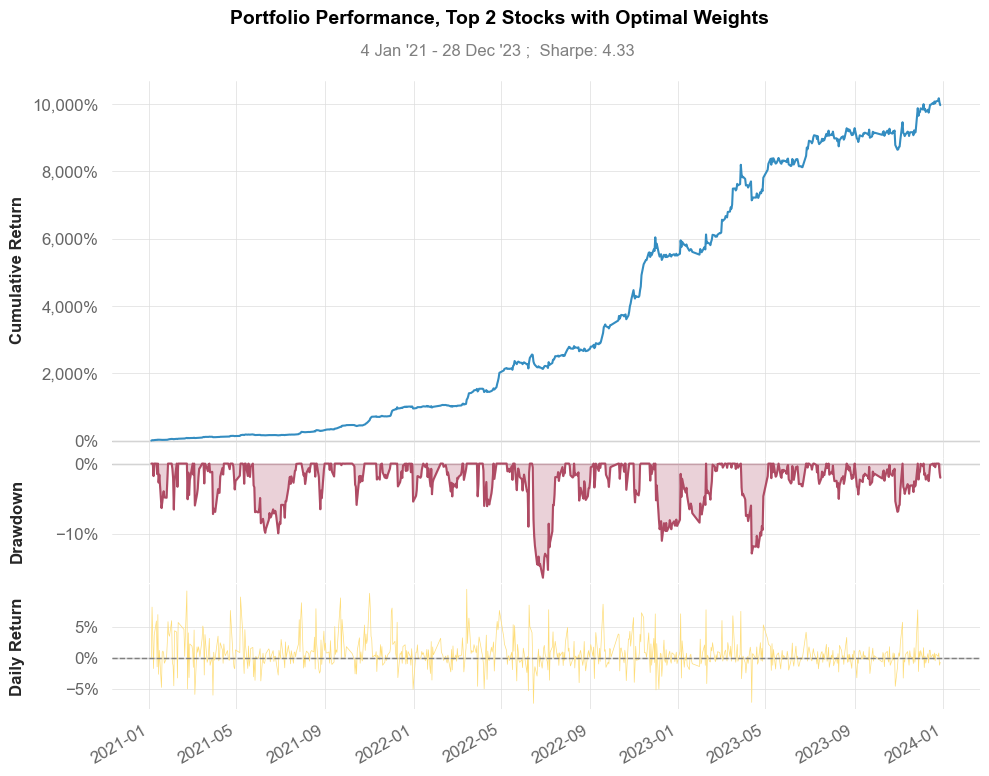

In [270]:
cal_and_plot_return(op_w_portfolio, title=f'Portfolio Performance, Top {n} Stocks with Optimal Weights')

起到了摊平风险的作用，夏普比率有所提升。虽然 4.33 的夏普比率不如均等分配的 Top-2 策略的 4.53，但累计超额收益率却比 Top-2 策略显著高出 $3000\%$。

### 追涨杀跌的 Top-k 策略

如果我们将 Top-2 股票视为更安全的资产，那么当 Top-1 股票面临大额下跌时，我们可以通过转移仓位以期实现止损，控制收益率的波动。因此，当 Top-1 和 Top-2 股票的收益率差小于某个阈值 r 时，我们可以将仓位转移到 Top-2 股票上。

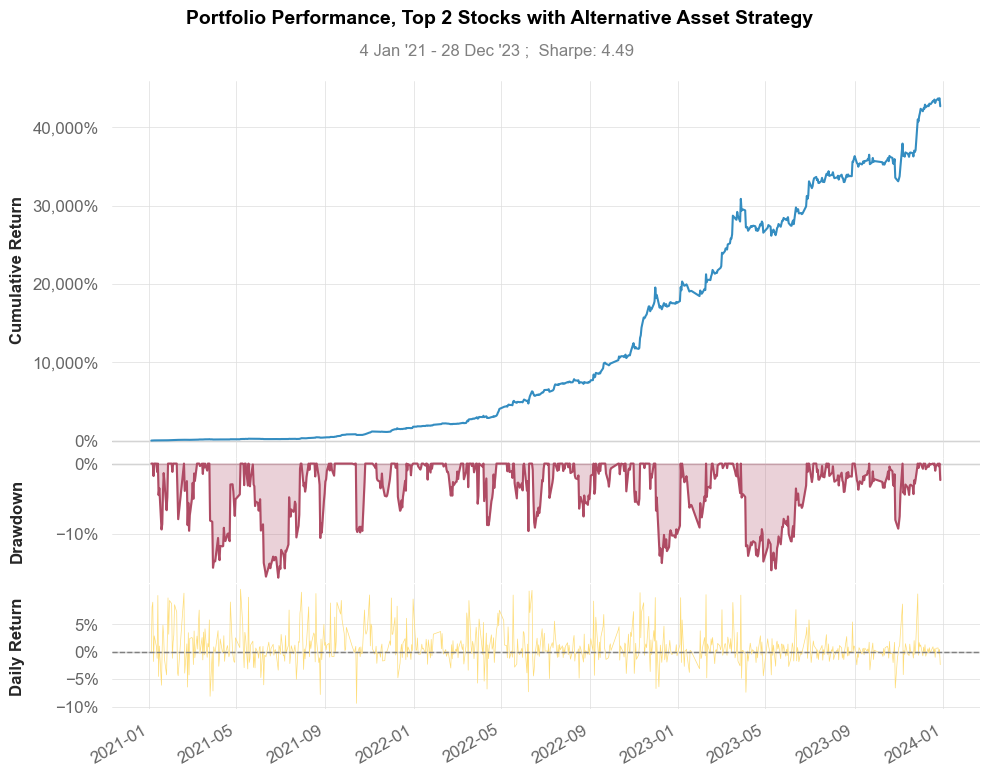

In [310]:
alt_portfolio = pred_pivot * 0  # 空仓初始化
r = 0.07

for date in optimal_weights.index:
    top_1_return = top_n_pct_change.loc[date][0]
    top_2_return = top_n_pct_change.loc[date][1]
    if top_1_return - top_2_return < r:
        alt_portfolio.loc[date, top_n[date][1]] = 1
    else:
        alt_portfolio.loc[date, top_n[date][0]] = 1

alt_portfolio = alt_portfolio.drop(alt_portfolio.index[-1])
alt_portfolio = alt_portfolio.div(alt_portfolio.sum(axis=1), axis=0)
alt_portfolio = alt_portfolio.fillna(0)
cal_and_plot_return(alt_portfolio, title=f'Portfolio Performance, Top {n} Stocks with Alternative Asset Strategy')

4.49 的夏普比率十分接近 Top-2 策略的 4.53，但是值得关注的是累计超额收益率达到了惊人的 $40000\%$。综合来看，这个策略最令人满意。

### 比较分析

我们先计算不同策略的超额收益率。

In [311]:
k_2_return = cal_return(k_2_portfolio)
op_w_return = cal_return(op_w_portfolio)
alt_return = cal_return(alt_portfolio)

portfolio_returns = [k_2_return, op_w_return, alt_return]
portfolio_names = ['Top-2', 'Optimal Weights', 'Alternative Asset']

for pr in portfolio_returns:
    pr = pr - hs300_test['pct_change']/100

In [312]:
cum_of_portfolio = []
for returns in portfolio_returns:
    cum_return = (1 + returns).cumprod().dropna().iloc[-1]
    cum_of_portfolio.append(cum_return)

mean_of_portfolio = []
for returns in portfolio_returns:
    mean = returns.mean()
    mean_of_portfolio.append(mean)

std_of_portfolio = []
for returns in portfolio_returns:
    std = returns.std()
    std_of_portfolio.append(std)

将收益均值和标准差的散点图绘制出来。

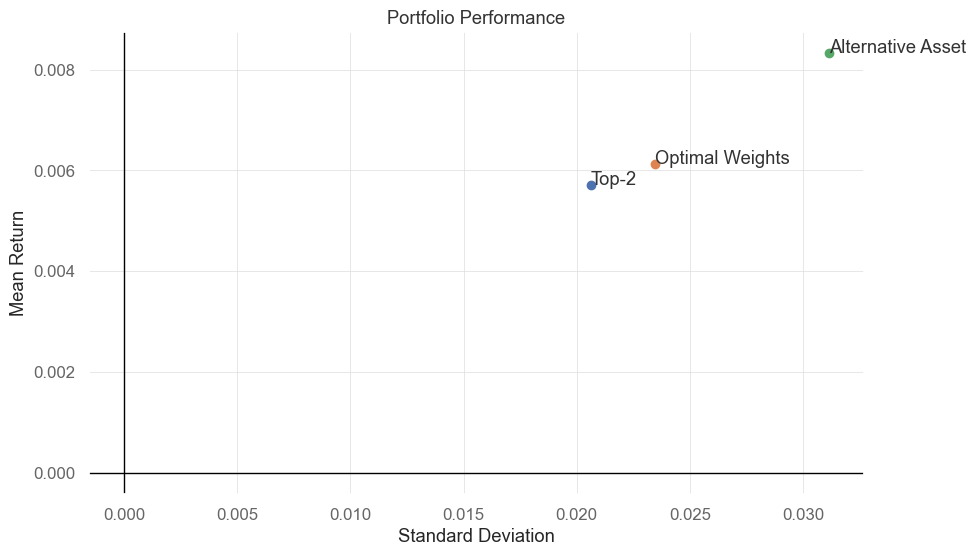

In [315]:
for i in range(len(portfolio_names)):
    plt.scatter(std_of_portfolio[i], mean_of_portfolio[i], label=portfolio_names[i])
    plt.text(std_of_portfolio[i], mean_of_portfolio[i], portfolio_names[i])

plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.xlabel('Standard Deviation')
plt.ylabel('Mean Return')
plt.title('Portfolio Performance')
plt.show()

实际看来，三者的夏普比率其实差异不大，但是追涨杀跌的 Top-k 策略的超额收益率却远高于其他两者，我们倾向于认为追涨杀跌的 Top-k 策略是最优策略。